In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
# from numpy.fft import fft2, fftshift, ifftshift

import tensorflow as tf

from scipy.integrate import simps

import sys
if not 'seaborn' in sys.modules:
    sys.path.append('/groups/turaga/home/turagas/research/')
    sys.path.append('/groups/turaga/home/turagas/anaconda3/lib/python3.5/site-packages/')
import seaborn as sns # Used only to set up plots
sns.set_context(context = 'talk')
# plt.style.use('dark_background')
# plt.rcParams['figure.facecolor'] = '#272b30'
plt.rcParams['image.cmap'] = 'viridis'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# create Tensorflow session
sess = tf.InteractiveSession()

In [43]:
# Setup the simulation parameters
wavelength = 0.68   # microns
NA         = 0.7    # Numerical aperture of the objective
nImmersion = 1.51   # Refractive index of the immersion oil
pixelSize  = 0.1    # microns
numPixels  = 2048   # Number of pixels in the camera; keep this even
power      = 0.1    # Watts
Z0         = 376.73 # Ohms; impedance of free space

In [4]:
# Create the image plane coordinates
x = np.linspace(-pixelSize * numPixels / 2, pixelSize * numPixels / 2, num = numPixels, endpoint = True)

In [5]:
# Create the Fourier plane
dx = x[1] - x[0]    # Sampling period, microns
fS = 1 / dx         # Spatial sampling frequency, inverse microns
df = fS / numPixels # Spacing between discrete frequency coordinates, inverse microns
fx = np.arange(-fS / 2, fS / 2, step = df) # Spatial frequency, inverse microns
kx, ky = np.meshgrid(fx,fx)

In [6]:
# Create the pupil, which is defined by the numerical aperture
fNA             = NA / wavelength # radius of the pupil, inverse microns
pupilRadius     = fNA / df        # pixels
pupilCenter     = numPixels / 2   # assumes numPixels is even
W, H            = np.meshgrid(np.arange(0, numPixels), np.arange(0, numPixels)) # coordinates of the array indexes
pupilMask       = 1.0*(np.sqrt((W - pupilCenter)**2 + (H - pupilCenter)**2) <= pupilRadius)

In [7]:
# Compute normalizing constant
norm_factor = simps(simps(np.abs(pupilMask)**2, dx = df), dx = df) / Z0 # A^2
print('Normalization constant:\t\t{:.4f} W'.format(np.sqrt(norm_factor)))

# Renormalize the pupil values
pupil = pupilMask * (1 + 0j)
normedPupil = pupil * np.sqrt(power / norm_factor)

new_power = simps(simps(np.abs(normedPupil)**2, dx = df), dx = df) / Z0
print('User-defined power:\t\t{:.4f} W'.format(power))
print('Power now carried by field:\t{:.4f} W'.format(new_power))

Normalization constant:		0.0940 W
User-defined power:		0.1000 W
Power now carried by field:	0.1000 W


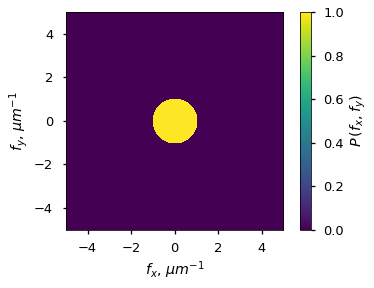

Power in pupil plane: 0.1000 W


In [8]:
# Show the pupil
ax = plt.imshow(np.abs(pupil), extent = [fx[0], fx[-1], fx[0], fx[-1]])
plt.grid(False)
cb = plt.colorbar(ax)
cb.set_label('$P \, ( f_x, f_y ) $')
plt.xlabel('$f_x$, $\mu m^{-1}$')
plt.ylabel('$f_y$, $\mu m^{-1}$')
plt.show()

# Compute the power
power_pupil = simps(simps(np.abs(normedPupil)**2, dx = df), dx = df) / Z0
print('Power in pupil plane: {:.4f} W'.format(power_pupil))

In [57]:
# Defocus from -10 micron to + 10 micron
defocusDistance = np.linspace(-15, 15, num=21)
defocusKernel      = np.zeros((defocusDistance.size, numPixels, numPixels),dtype=np.complex64)
defocusPSF      = np.zeros((defocusDistance.size, numPixels, numPixels),dtype=np.float64)

for ctr, z in enumerate(defocusDistance):
    # Add 0j to ensure that np.sqrt knows that its argument is complex
    defocusPhaseAngle            = 1j * z / pixelSize * np.sqrt((2 * np.pi * nImmersion / wavelength)**2 - kx**2 - ky**2 + 0j)
    defocusKernel[ctr,:,:]       = np.exp(defocusPhaseAngle)
#     defocusKernel[ctr,:,:] = np.cos(defocusPhaseAngle) + 1j*np.sin(defocusPhaseAngle)
    defocusPupil        = pupil * np.squeeze(defocusKernel[ctr,:,:])
    defocusPSFA         = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(defocusPupil))) * df**2
    defocusPSF[ctr,:,:] = np.real(defocusPSFA * np.conj(defocusPSFA))

0.02941026680811244


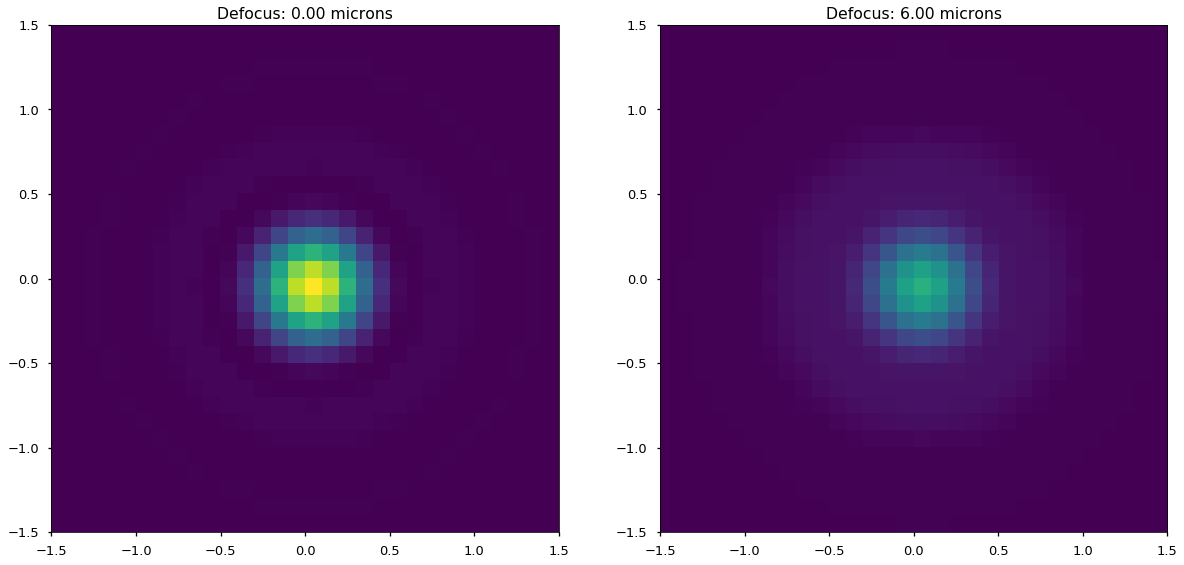

In [58]:
fig, (ax0, ax1) = plt.subplots(nrows = 1, ncols = 2, figsize=(20,10))

indx      = [10, 14] # indexes to defocus distances to plot

# Find the maximum in the in-focus image for displaying PSF's on the correct intensity scale
# maxIrradiance = np.max(psf_defocus_np)/Z0
maxIrradiance = np.max(defocusPSF[10,:,:])/Z0
print(maxIrradiance)

lim=1.5

ax=ax0
# image = psf_defocus_np[indx[0], :, :] / Z0
image = (defocusPSF[indx[0], :, :] / Z0)
img = ax.imshow(image, interpolation='nearest', extent = [x[0], x[-1], x[0], x[-1]], vmin =0, vmax = maxIrradiance)
# cb = plt.colorbar(img)
ax.set_xlim((-lim, lim))
ax.set_ylim((-lim, lim))
ax.set_title('Defocus: {0:.2f} microns'.format(defocusDistance[indx[0]]))

ax=ax1
# image = psf_defocus_np[indx[1], :, :] / Z0
image = (defocusPSF[indx[1], :, :] / Z0)
img = ax.imshow(image, interpolation='nearest', extent = [x[0], x[-1], x[0], x[-1]], vmin =0, vmax = maxIrradiance)
# cb = plt.colorbar(img)
ax.set_xlim((-lim, lim))
ax.set_ylim((-lim, lim))
ax.set_title('Defocus: {0:.2f} microns'.format(defocusDistance[indx[1]]))

# plt.tight_layout()
plt.show()

0.02941026680811244


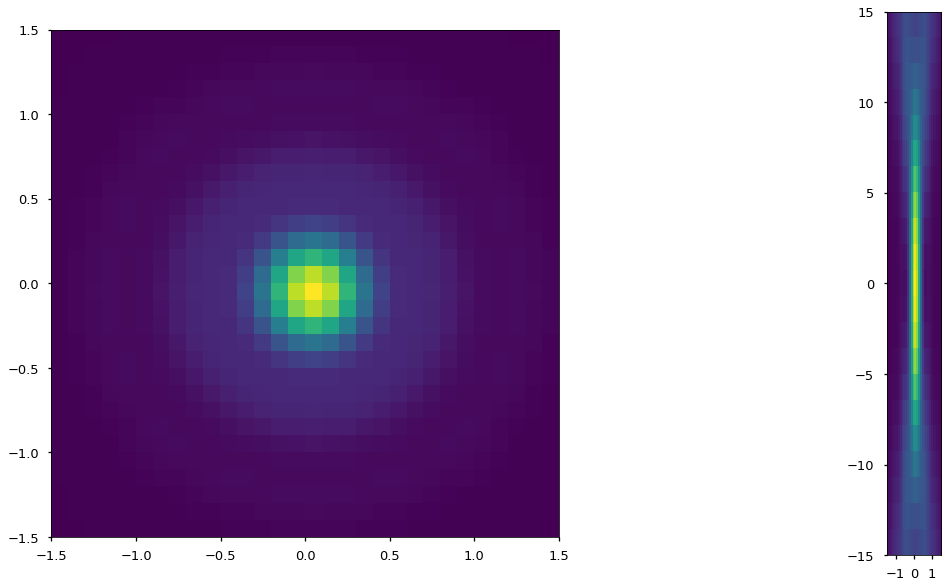

In [59]:
fig, (ax0, ax1) = plt.subplots(nrows = 1, ncols = 2, figsize=(20,10))

# Find the maximum in the in-focus image for displaying PSF's on the correct intensity scale
# maxIrradiance = np.max(psf_defocus_np)/Z0
maxIrradiance = np.max(defocusPSF[10,:,:])/Z0
print(maxIrradiance)

lim=1.5

ax=ax0
# image = psf_defocus_np[indx[0], :, :] / Z0
image = np.sum(defocusPSF / Z0, axis=0)
img = ax.imshow(image, interpolation='nearest', extent = [x[0], x[-1], x[0], x[-1]])#, vmin =0, vmax = maxIrradiance)
# cb = plt.colorbar(img)
ax.set_xlim((-lim, lim))
ax.set_ylim((-lim, lim))
# ax.set_title('Defocus: {0:.2f} microns'.format(defocusDistance[indx[0]]))

ax=ax1
# image = psf_defocus_np[indx[1], :, :] / Z0
image = np.sum(defocusPSF / Z0, axis=2)
img = ax.imshow(image, interpolation='nearest', extent = [x[0], x[-1], defocusDistance[0], defocusDistance[-1]])#, vmin =0, vmax = maxIrradiance)
# cb = plt.colorbar(img)
ax.set_xlim((-lim, lim))
# ax.set_ylim((-lim, lim))
# ax.set_title('Defocus: {0:.2f} microns'.format(defocusDistance[indx[1]]))

# plt.tight_layout()
plt.show()

In [60]:
defocusDistance

array([-15. , -13.5, -12. , -10.5,  -9. ,  -7.5,  -6. ,  -4.5,  -3. ,
        -1.5,   0. ,   1.5,   3. ,   4.5,   6. ,   7.5,   9. ,  10.5,
        12. ,  13.5,  15. ])

In [61]:
def fftshift(input,axis=1):
    split_size_right = tf.floordiv(tf.shape(input)[axis],2)
    split_sizes = [tf.shape(input)[axis]-split_size_right, split_size_right]
    pos, neg = tf.split(input,split_sizes,axis=axis)
    input = tf.concat([neg,pos],axis=axis)
    return input

def ifftshift(input,axis=1):
    split_size_left = tf.floordiv(tf.shape(input)[axis],2)
    split_sizes = [split_size_left, tf.shape(input)[axis]-split_size_left]
    pos, neg = tf.split(input,2,axis=axis)
    input = tf.concat([neg,pos],axis=axis)
    return input

def fftshift2d(input):
    for axis in [1,2]:
        ax = input.shape.ndims-axis
        input = fftshift(input,axis=ax)
    return input
    
def ifftshift2d(input):
    for axis in [1,2]:
        ax = input.shape.ndims-axis
        input = ifftshift(input,axis=ax)
    return input

In [62]:
# # create pupil mask
# mask = tf.constant(pupilMask,dtype=tf.complex64)

# # initial pupil function has amplitude same as the mask, phase = 0
# pupil = tf.Variable(normedPupil.astype(np.complex64)*df**2,dtype=tf.complex64)

# # pupil function
# pupil_mask = tf.multiply(mask,pupil)

# # PSF is Fourier transform of pupil function
# psf = fftshift2d(tf.fft2d(ifftshift2d(pupil_mask)))

In [63]:
pij2 = tf.constant(np.pi*2j,dtype=tf.complex64)

# create pupil amplitude
pupil_amp = tf.constant(normedPupil.astype(np.complex64)*df**2,dtype=tf.complex64)

# initial pupil phase function has phase = 0
pupil_phase_angle = tf.zeros_like(pupil_amp,dtype=tf.complex64,optimize=True)
pupil_phase = tf.exp(tf.scalar_mul(pij2,pupil_phase_angle))

# defocus function
defocus = tf.constant(defocusKernel,dtype=tf.complex64)

# pupil function
pupil = tf.multiply(pupil_amp,pupil_phase)

# pupil function * defocus
pupil_defocus = tf.multiply(pupil,defocus)

# PSF is Fourier transform of pupil function
psf_defocus = fftshift2d(tf.fft2d(ifftshift2d(pupil_defocus)))
psf = fftshift2d(tf.fft2d(ifftshift2d(pupil)))

psf_defocus = tf.square(tf.abs(psf_defocus))
psf = tf.square(tf.abs(psf))

In [64]:
# initialize trainable_variables
sess.run(tf.global_variables_initializer())
# calculate pupil function and PSF
psf_np, psf_defocus_np, pupil_defocus_np = sess.run([psf, psf_defocus, pupil_defocus])

0.33286230376726617


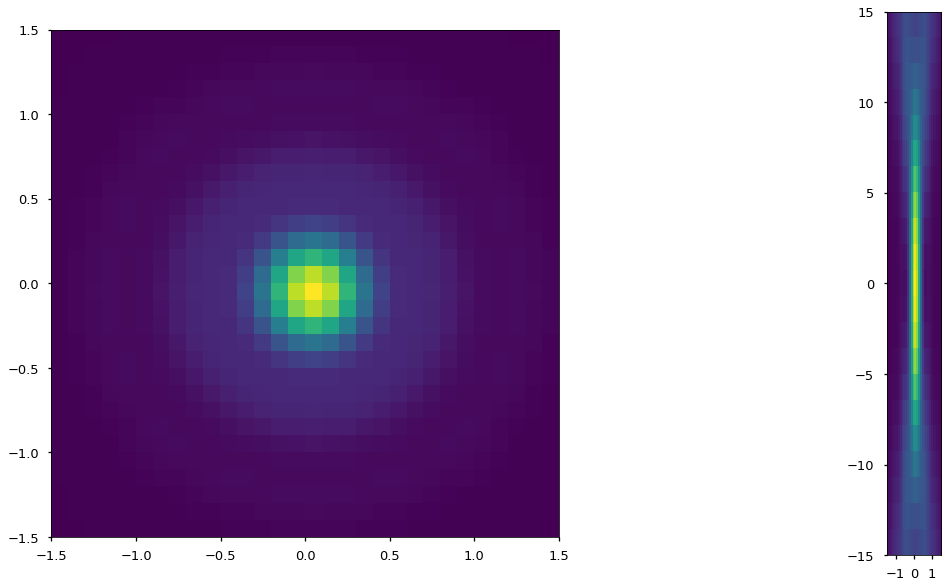

In [83]:
# lim=0.7

# image = psf_np / Z0
# plt.figure(figsize=(10,10))
# img = plt.imshow(image, interpolation='nearest', extent = [x[0], x[-1], x[0], x[-1]])
# cb = plt.colorbar(img)
# plt.gca().set_xlim((-lim, lim))
# plt.gca().set_ylim((-lim, lim))
# plt.title('Tensorflow PSF')

# plt.xlabel('x, $\mu m$')
# plt.ylabel('y, $\mu m$')
# cb.set_label('Irradiance, $W / \mu m^2$')
# plt.grid(False)
# plt.show()


fig, (ax0, ax1) = plt.subplots(nrows = 1, ncols = 2, figsize=(20,10))

# Find the maximum in the in-focus image for displaying PSF's on the correct intensity scale
maxIrradiance = np.max(psf_defocus_np)/Z0
# maxIrradiance = np.max(defocusPSF[10,:,:])/Z0
print(maxIrradiance)

lim=1.5

ax=ax0
# image = psf_defocus_np[indx[0], :, :] / Z0
image = np.sum(psf_defocus_np / Z0, axis=0)
img = ax.imshow(image, interpolation='nearest', extent = [x[0], x[-1], x[0], x[-1]])#, vmin =0, vmax = maxIrradiance)
# cb = plt.colorbar(img)
ax.set_xlim((-lim, lim))
ax.set_ylim((-lim, lim))
# ax.set_title('Defocus: {0:.2f} microns'.format(defocusDistance[indx[0]]))

ax=ax1
# image = psf_defocus_np[indx[1], :, :] / Z0
image = np.sum(psf_defocus_np / Z0, axis=2)
img = ax.imshow(image, interpolation='nearest', extent = [x[0], x[-1], defocusDistance[0], defocusDistance[-1]])#, vmin =0, vmax = maxIrradiance)
# cb = plt.colorbar(img)
ax.set_xlim((-lim, lim))
# ax.set_ylim((-lim, lim))
# ax.set_title('Defocus: {0:.2f} microns'.format(defocusDistance[indx[1]]))

# plt.tight_layout()
plt.show()

In [78]:
simps(simps(np.abs(pupilMask)**2, dx = df), dx = df) / Z0

0.008835566083152124

In [79]:
np.sum(np.sum(np.abs(pupilMask)**2))*df*df

3.3286228105059